# Сегментация изображений с камеры беспилотника

Мы будем использовать данные с [Lyft Udacity Challenge](https://www.udacity.com/lyft-challenge)

## Подготовка датасета

#### Скачивание данных

In [1]:
! pip install wldhx.yadisk-direct

In [2]:
!curl -L $(yadisk-direct https://disk.yandex.com/d/jJrOLbYlBYVESQ) -o lyft_segmentation.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 2620M  100 2620M    0     0  21.0M      0  0:02:04  0:02:04 --:--:-- 21.2M


In [3]:
! unzip -qq lyft_segmentation.zip

#### Загрузка датасета

Давайте поймем, как устроен датасет для задачи сегментации. Затем откроем несколько картинок и посмотрим на них.

In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

Обучающий датасет для задачи сегментации обычно представляет собой две папки с картинками.

- images:
    - img01.jpg
    - img02.jpg
    - ...
- segmentations:
    - img01.jpg
    - img02.jpg
    - ...


В папке images лежат RGB картинки, которые подаются сети на вход. В папке segmentation лежат карты сегментации к картинкам из папки images.

Карта сегментации — это двумерная картинка, на которой пиксели разных классов имеют разные значения. Например, откроем одну из картинок:

In [5]:
DATA_ROOT = '/kaggle/input/lyft-udacity-challenge/'

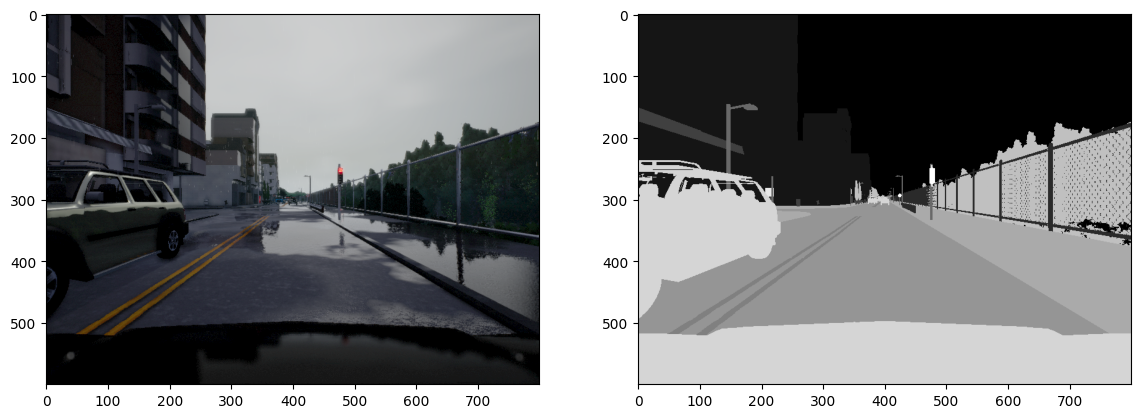

In [6]:
# считываем картинку и ее карту сегментации
img = plt.imread('./lyft_segmentation/images/02_00_000.png')
img_seg = plt.imread('./lyft_segmentation/segmentation_masks/02_00_000.png')

# отрисовываем две картинки рядом друг с другом
_, axes = plt.subplots(1,2, figsize=(14,10))
axes[0].imshow(img);
axes[1].imshow(img_seg[..., 0], cmap='gray');

Как видно, на карте сегментации разными градиациями серого обозначены разные классы. Давайте посмотрим, сколько всего есть различных классов. Для этого посмотрим, сколько различных значений пикселей есть на картинке:

In [7]:
np.unique(img_seg * 255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

Как видим, классов сегментации у нас всего 13.

Давайте заведем словарь соответствия классам номерам:

In [8]:
labels = {
    0: 'Unlabeled',
    1: 'Building',
    2: 'Fence',
    3: 'Other',
    4: 'Pedestrian',
    5: 'Pole',
    6: 'Roadline',
    7: 'Road',
    8: 'Sidewalk',
    9: 'Vegetation',
    10: 'Car',
    11: 'Wall',
    12: 'Traffic sign'
}

Код ниже для картинки отрисовывает изображения ее карт сегментации для каждого класса сегментации по отдельности. Можете попробовать запустить этот код для разных картинок.

[  0 255]


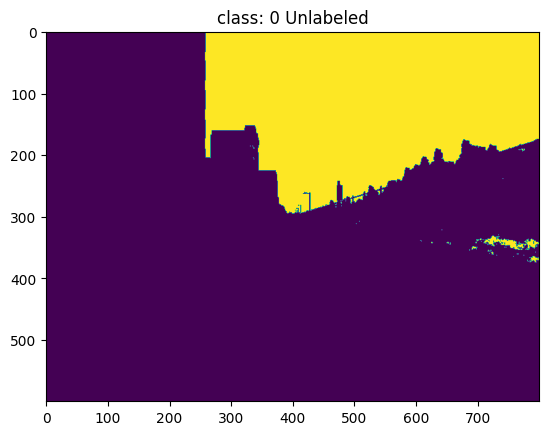

[  0 255]


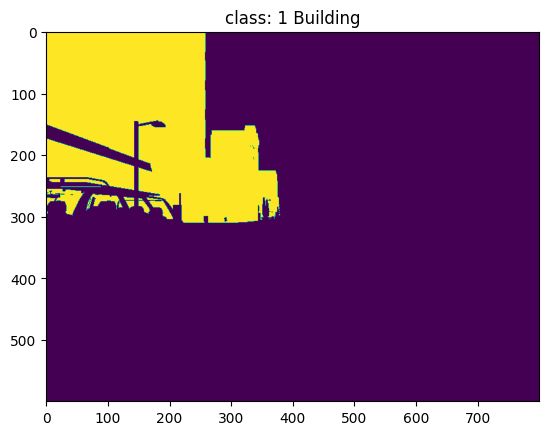

[  0 255]


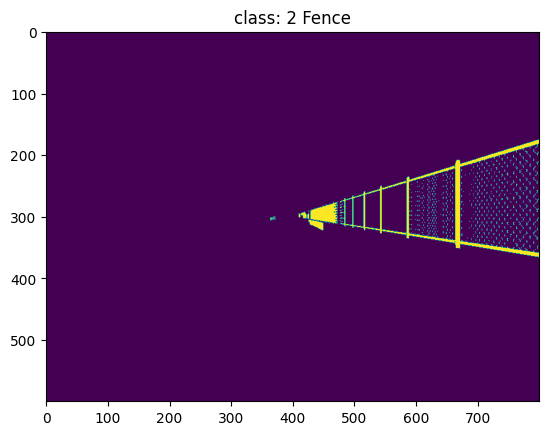

[  0 255]


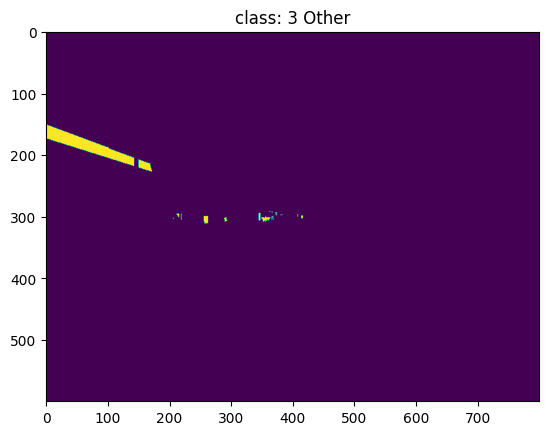

[0]


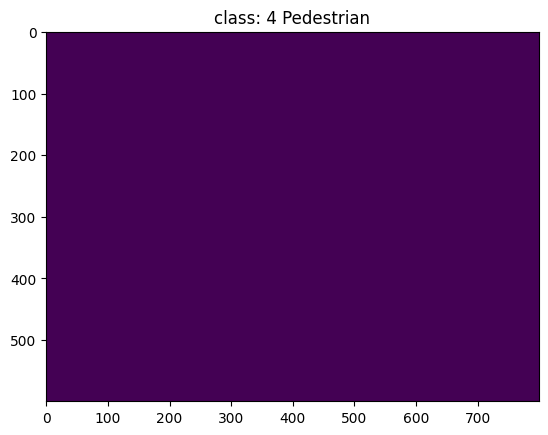

[  0 255]


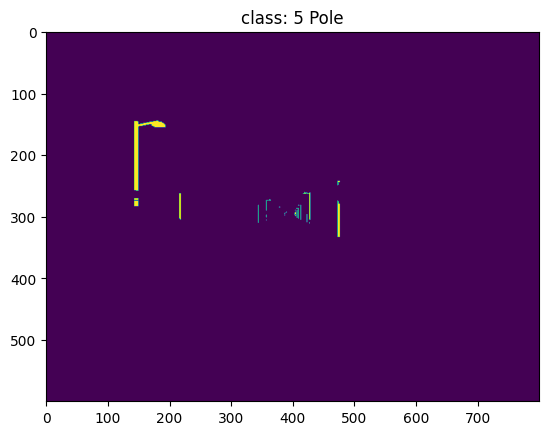

[  0 255]


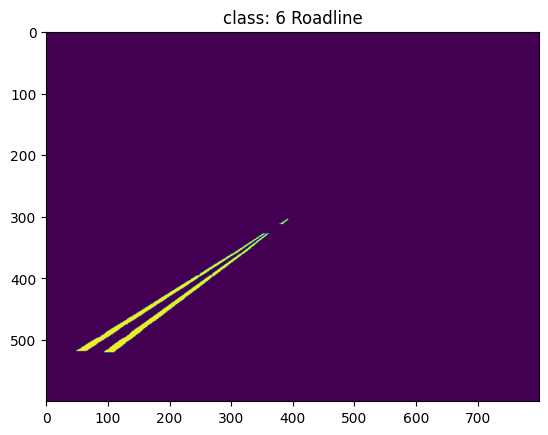

[  0 255]


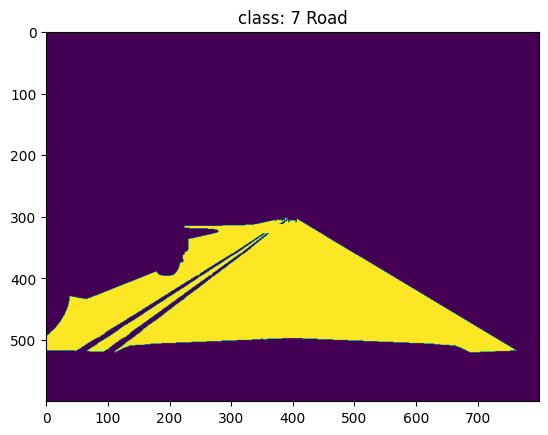

[  0 255]


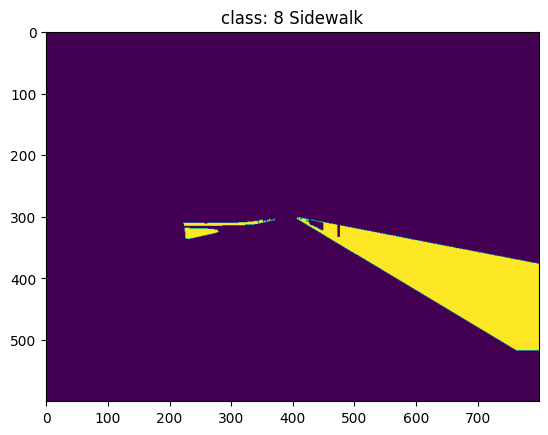

[  0 255]


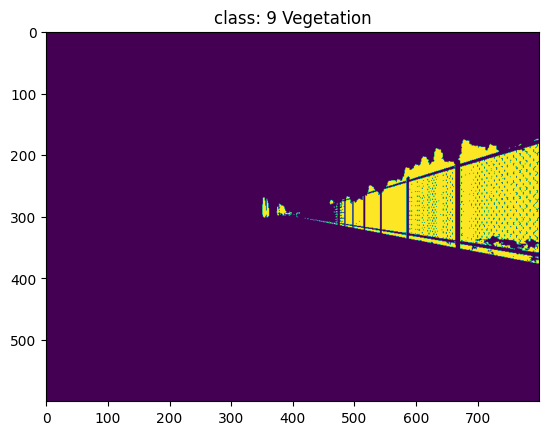

[  0 255]


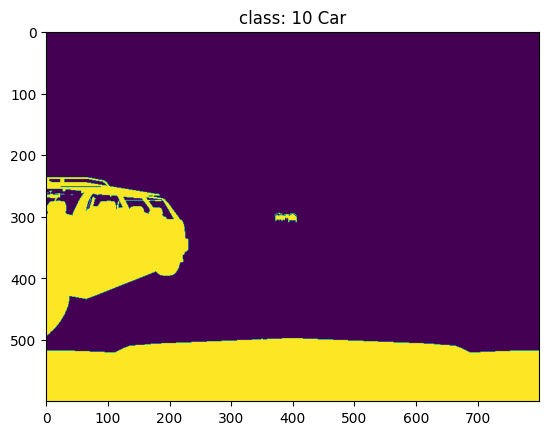

[  0 255]


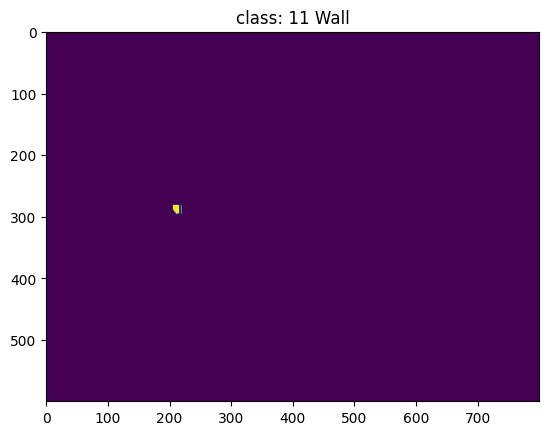

[  0 255]


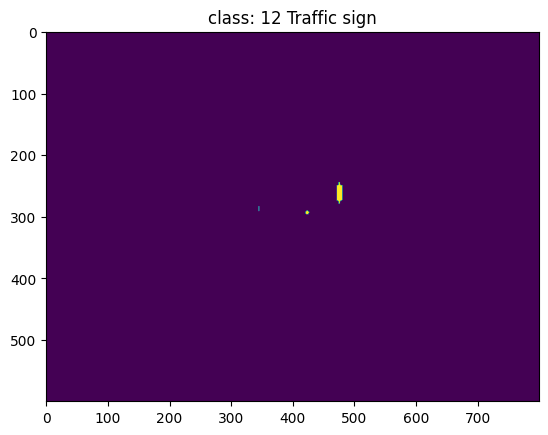

In [9]:
# здесь выберите название картинки
img = '02_00_001'


for i in range(13):
    mask = plt.imread('./lyft_segmentation/segmentation_masks/{}.png'.format(img)) * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

#### Создание Dataset

Теперь создадим датасет из этих данных датасет для обучения модели. К сожалению, в PyTorch нет удобной функции для автоматического создания Dataset из данных для задачи сегментации, поэтому его придется написать вручную.

Для начала создадим два списка:
- список с путями до RGB картинок;
- список с путями до карт сегментаций этих картинок;

In [10]:
images = []
segmentation_masks = []

for img_name in os.listdir('./lyft_segmentation/images/'):
    images.append('./lyft_segmentation/images/' + img_name)

for img_name in os.listdir('./lyft_segmentation/segmentation_masks/'):
    segmentation_masks.append('./lyft_segmentation/segmentation_masks/' + img_name)

In [11]:
images[:5], segmentation_masks[:5]

(['./lyft_segmentation/images/07_00_028.png',
  './lyft_segmentation/images/04_00_091.png',
  './lyft_segmentation/images/03_01_191.png',
  './lyft_segmentation/images/F64-9.png',
  './lyft_segmentation/images/09_00_074.png'],
 ['./lyft_segmentation/segmentation_masks/07_00_028.png',
  './lyft_segmentation/segmentation_masks/04_00_091.png',
  './lyft_segmentation/segmentation_masks/03_01_191.png',
  './lyft_segmentation/segmentation_masks/F64-9.png',
  './lyft_segmentation/segmentation_masks/09_00_074.png'])

Теперь создадим кастомный датасет torch.utils.data.Dataset для удобной работы c нашими данными в PyTorch.

In [12]:
! pip install torchvision

In [13]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

Создаем класс для кастомного датасета. Давайте упростим задачу: будем сегментировать картинки только на четыре класса из представленных тринадцати:
- unlabeled;
- building;
- road;
- car.

После занятия вы самостоятельно можете попробовать решить более сложную задачу и сегментировать картинки датасета на большее количество классов.

In [14]:
class SelfDrivingDataset(Dataset):
    def __init__(self, images, segmentation_masks):

        self.images = images
        self.segmentation_masks = segmentation_masks

        self.images_transforms = transforms.Compose([
            transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        ])

        self.masks_transforms = transforms.Compose([
            # используем InterpolationMode.NEAREST, чтобы при изменении размера
            # маски сегментации не менялись номера классов
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        ])

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-сегментация (index)
        возвращать эту пару. Этот метод обязательно нужно реализовывать во всех
        кастомных классах Dataset. Перед тем, как выдать на выходе
        пару картинка-сегментация, можно применить к картинкам любые преобразования:
        например, знакомую нам аугментацию.
        '''

        # загружаем нужные картинку и ее карту сегментации
        img = Image.open(self.images[index])
        mask = Image.open(self.segmentation_masks[index])

        # # применяем предобработку к RGB картинке
        img = self.images_transforms(img)
        # # применяем предобработку к маске сегментации
        mask = self.masks_transforms(mask)*255

        # # делим маску сегментации на 13 бинарных масок сегментации
        # # отдельно для каждого класса
        masks = []

        # вытаскиваем пиксели, принадлежащие классам unlabeled, building, road и car.
        for i in [0, 1, 7, 10]:
            # генерируем бинарную маску сегментации для текущего класса i
            cls_mask = torch.where(mask==i, 1, 0)
            masks.append(cls_mask[0,:,:].numpy())

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        # схлопываем бинарные карты сегментации в одну
        masks = torch.argmax(masks, axis=0)

        # возвращаем пару: картинка — ее маска сегментации на 4 класса
        return (img, masks)

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-сегментация в датасете
        '''
        return len(self.images)

Заведем массив классов, на которые мы будем сегментировать картинки. Он пригодится нам ниже, когда мы при обучении сети будем отрисовывать промежуточные результаты сегментации.

In [15]:
labels_used = ['Unlabeled', 'Building', 'Road', 'Car']

Проверим, что наш Dataset работает. Заведем переменную датасета и возьмем нулевой элемент. Отрисуем картинку и одну из ее бинарных карт сегментации.

<ipython-input-14-3a0103cb3e68>:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([256, 256])


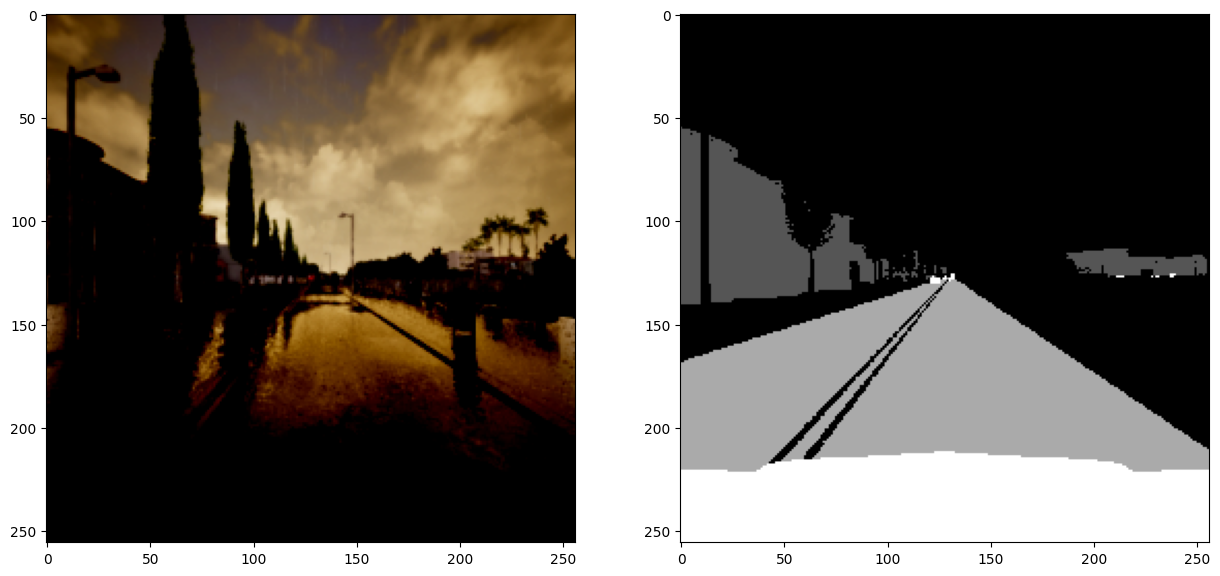

In [16]:
dataset = SelfDrivingDataset(images, segmentation_masks)

# dataset[3] — это вызов метода __getitem__(3)
img, mask = dataset[3]

print(img.shape, mask.shape)

# отрисовываем картинку и ее маску сегментации
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
# показываем бинарную маску 7 класса — "road"
ax[1].imshow(mask, cmap='gray')
plt.show()

Разделим выборку на train и val:

In [17]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

И заведем даталоадеры:

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)

## Создание модели

Проверим, доступен ли нам GPU:

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Объявляем класс модели. Реализуем несложную SegNet.

На лекции мы не очень подробно обсудили все нюансы transposed convolution: мы лишь поняли идею его работы, что этот слой основан на той же идее, что операция свертки и что он помогает увеличить размер карт активаций.

Чтобы успешно применять слой transposed convolution на практике, вам могут быть полезны следующие ссылки:
- [документация pytorch](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) по слою transposed convolution. Тут вы найдете все параметры, которые есть у слоя, и формулу вычисления размера выхода слоя по размеру входа и значениям параметров;
- [визуализация](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) работы слоя transposed convolution для разных значений параметров

In [20]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_bn0 = nn.BatchNorm2d(num_features=8)

        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_bn1 = nn.BatchNorm2d(num_features=8)

        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_bn2 = nn.BatchNorm2d(num_features=16)


        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_bn0 = nn.BatchNorm2d(num_features=32)
        # слой ConvTranspose2d c такими параметрами не меняет размер
        # карт активаций.
        self.dec_conv0 = nn.ConvTranspose2d(32, 8, 3, padding=1)

        self.upsample1 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_bn1 = nn.BatchNorm2d(num_features=16)
        self.dec_conv1 = nn.ConvTranspose2d(16, 8, 3, padding=1)

        self.upsample2 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_bn2 = nn.BatchNorm2d(num_features=16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 4, 3, padding=1)


    def forward(self, x):
        # encoder
        e0 = self.enc_bn0(self.pool0(F.relu(self.enc_conv0(x))))
        e1 = self.enc_bn1(self.pool1(F.relu(self.enc_conv1(e0))))
        e2 = self.enc_bn2(self.pool2(F.relu(self.enc_conv2(e1))))

        # bottleneck
        b = self.bottleneck_conv(e2)

        # decoder
        d0 = self.dec_conv0(self.dec_bn0(F.relu(self.upsample0(torch.cat([b, e2], 1)))))
        d1 = self.dec_conv1(self.dec_bn1(F.relu(self.upsample1(torch.cat([d0, e1], 1)))))
        d2 = self.dec_conv2(self.dec_bn2(F.relu(self.upsample2(torch.cat([d1, e0], 1)))))

        return d2

## Обучение модели

Функция обучения модели:

In [21]:
from IPython.display import clear_output

def train(model, opt, loss_fn, epochs, data_train, data_val):

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for i, (X_batch, Y_batch) in enumerate(data_train):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            Y_pred = model(X_batch)
            # Y_pred = torch.flatten(Y_pred, start_dim=2, end_dim=-1)
            # Y_batch = torch.flatten(Y_batch, start_dim=1, end_dim=-1)
            loss = loss_fn(Y_pred, Y_batch.long())
            loss.backward()
            opt.step()
            opt.zero_grad()


            avg_loss += loss.item()

            # после каждой эпохи будем визуализировать сегментацию на шести картинках из data_val

            if i%10 == 0:

                # выводим средний лосс на последних 10 обучающих итерациях
                print(f'avg train loss: {avg_loss / 10}')

                model.eval()
                # получаем один батч из data_val
                X_val, Y_val = next(iter(data_val))
                # получаем ответ сети на картинки из батча
                Y_pred = model(X_val.to(device))
                Y_hat = Y_pred.detach().cpu().numpy()
                Y_hat = np.argmax(Y_hat, axis=1)


                # визуализация ответов сети
                clear_output(wait=True)
                _, axes = plt.subplots(6, 6, figsize=((len(labels_used)+2)*4, 6*4))
                for k in range(6):

                    # отрисовываем 6 картинок, поданных на вход сети
                    # картинки нормализованы, поэтому могут выглядеть непривычно
                    axes[0][k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray', aspect='auto')
                    axes[0][k].title.set_text('Input')

                    # отрисовываем правильные маску сегментации для шести картинок выше
                    axes[1][k].imshow(Y_val[k].numpy(), cmap='gray', aspect='auto')
                    axes[1][k].title.set_text('Real Map')

                    # отрисовываем ответы сети для каждого из четырех классов сегментации в отдельности
                    for j in range(len(labels_used)):
                        axes[j+2][k].imshow(np.where(Y_hat[k]==j, 1, 0), cmap='gray', aspect='auto')
                        axes[j+2][k].title.set_text('Output for {}'.format(labels_used[j]))
                plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
                plt.show()

            model.train()
            avg_loss = 0

Запустим обучение сети:

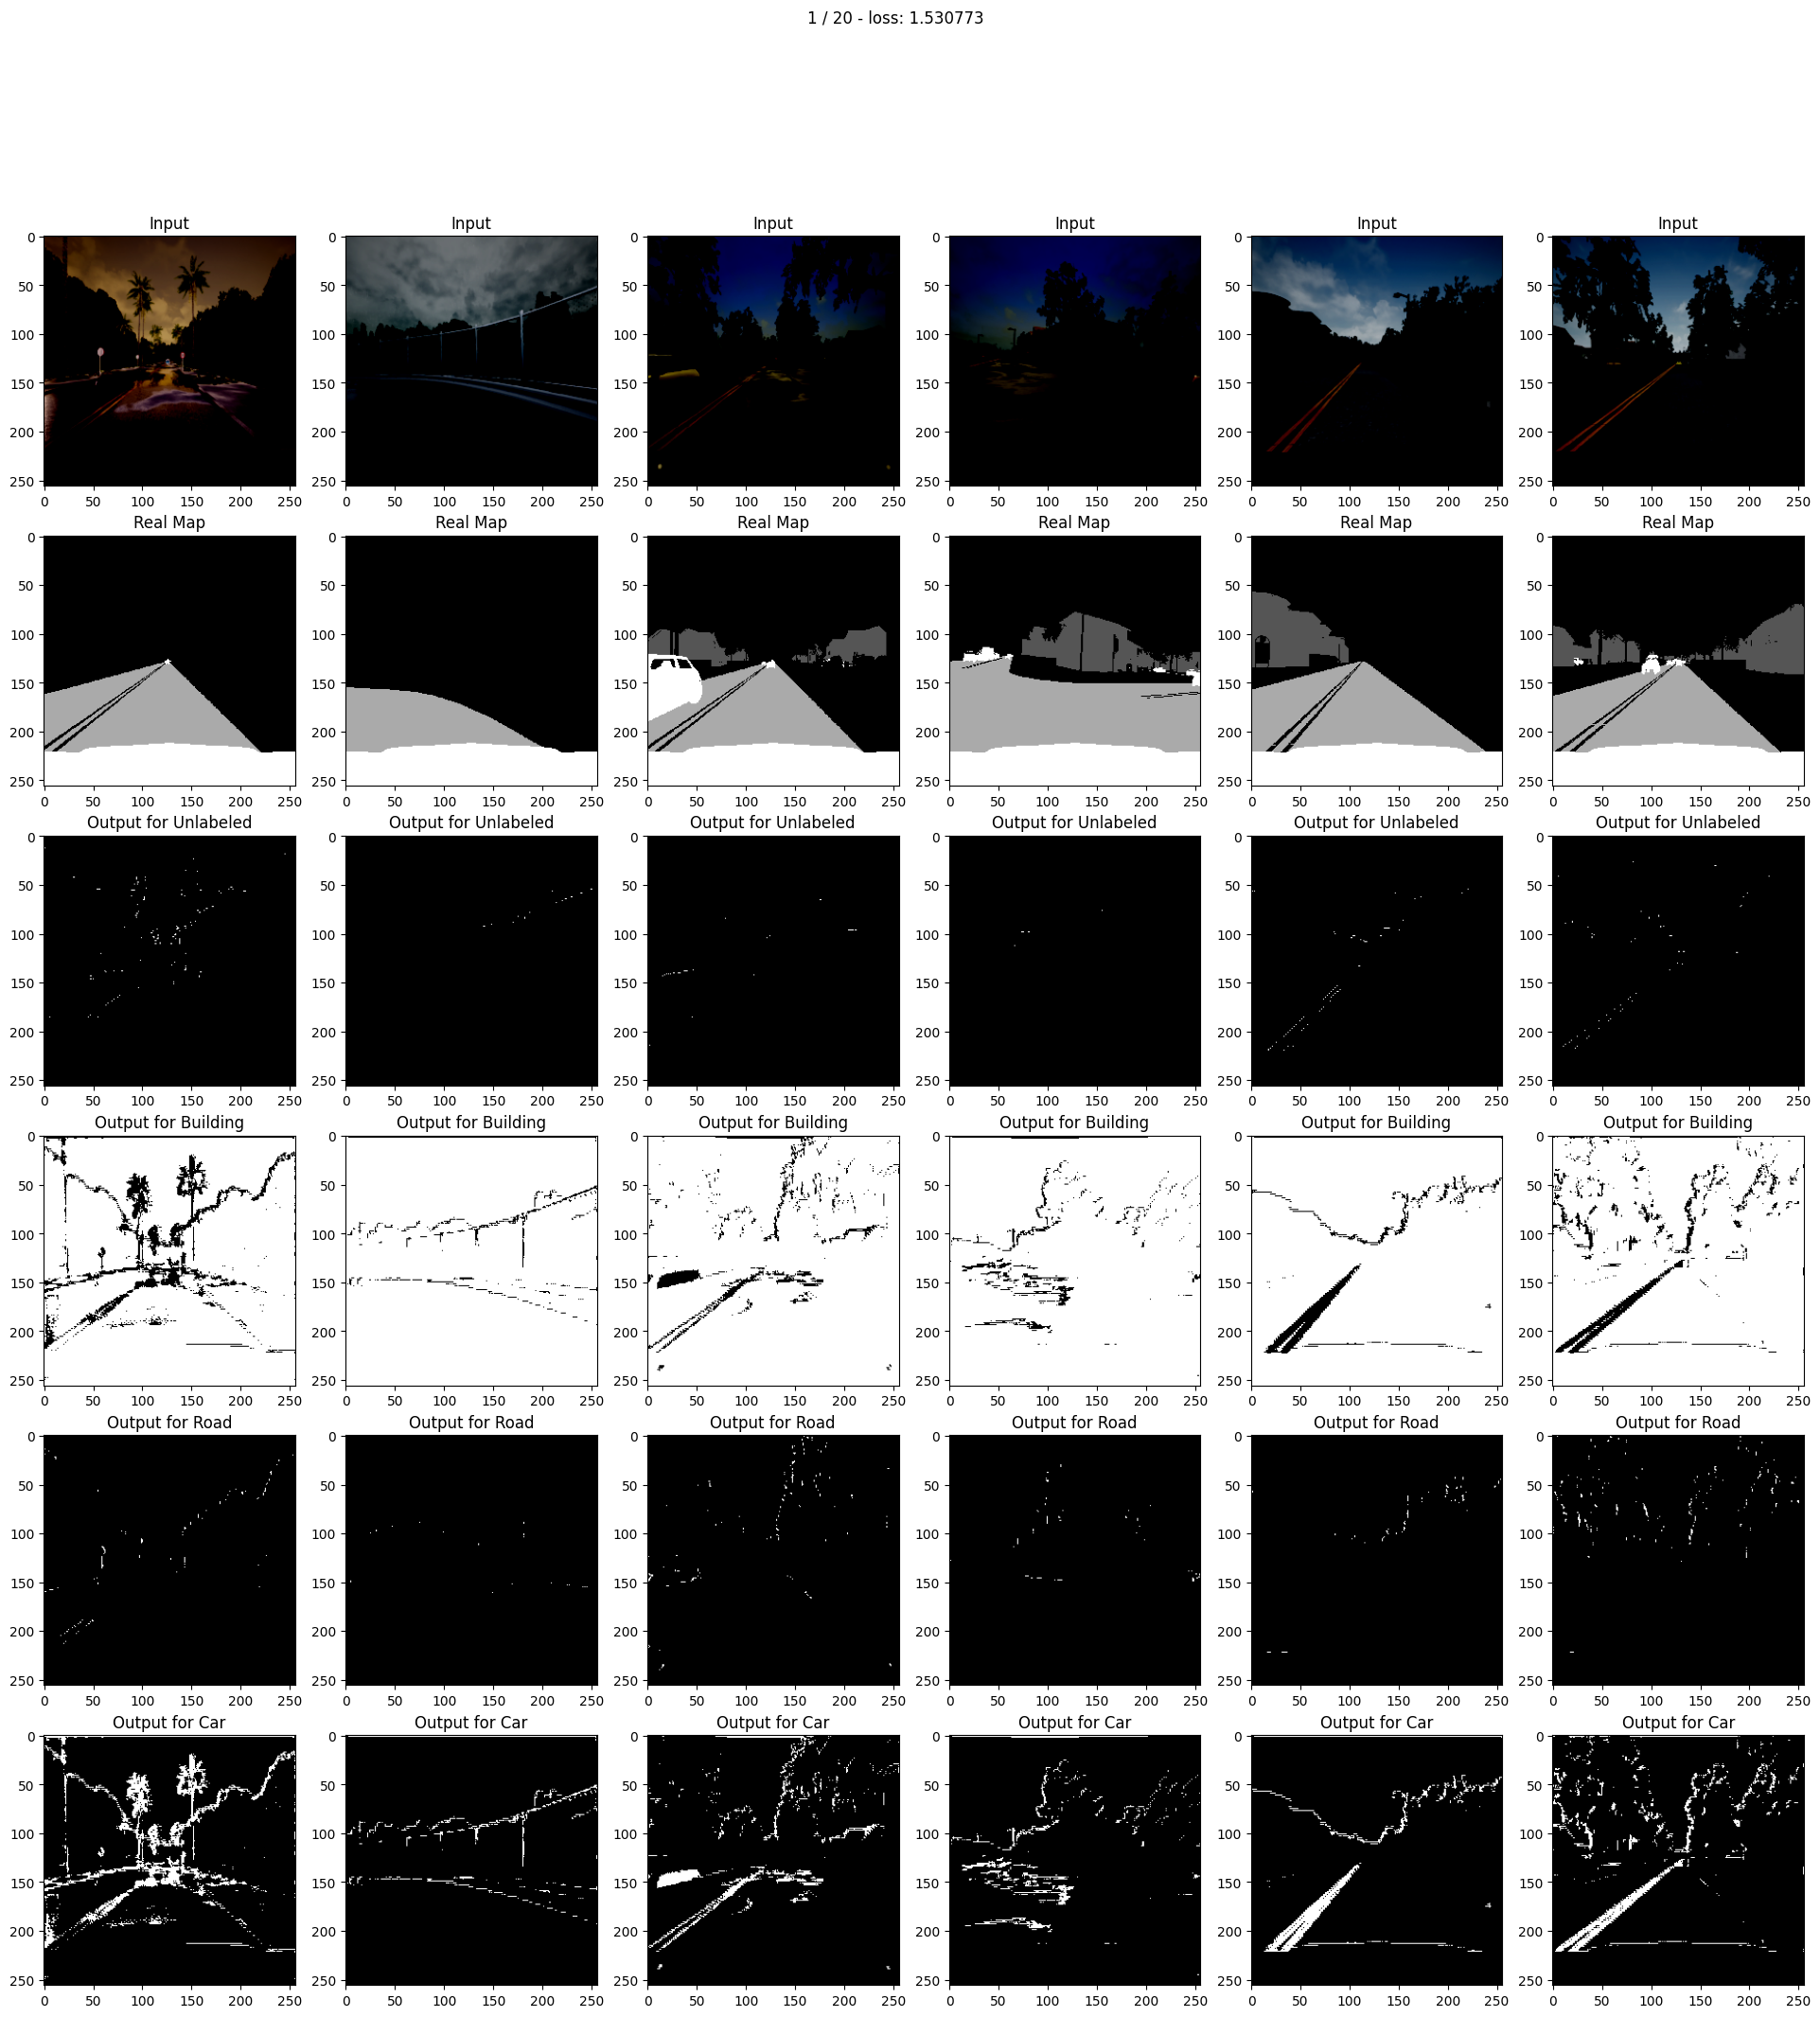

avg train loss: 0.10164790153503418


In [ ]:
model = SegNet().to(device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, loss, 20, train_loader, val_loader)

In [ ]:

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
# model

## Что дальше

Мы с вами создали и обучили простенькую нейросеть типа SegNet для сегментации картинок на 4 класса. Наша сеть работает не то чтобы отлично, и вы можете попытаться ее улучшить. Вот что можно сделать:
- изменить количество слоев и/или их параметры. К примеру, в декодере мы использовали слои upsampling и transposed convolution, которые не увеличивали размер карт активации. На самом деле, может быть довольно полезно использовать слои transposed convolution, которые увеличивают размер карт активации. И тогда слои upsampling использовать будет уже не нужно.

- часто делают так: используют слои transposed convolution, которые увеличивают размер карт активации, и между ними вставляют обычные слои convolution. Пример такого устройства сети [можно посмотреть тут](https://www.kaggle.com/code/robinreni/pytorch-segnet-deeplabv3-training/notebook)

- сделать сеть по типу U-Net: добавить skip connections между слоями encoder и decoder;
- обучить нейросеть с помощью другой лосс-функции. Например, [Dice](https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient) — это лосс-функция для задачи семантической сегментации.



#### Пример добавления skip connection к нашей сети выше:

In [ ]:
class my_SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_bn0 = nn.BatchNorm2d(num_features=8)
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_bn1 = nn.BatchNorm2d(num_features=8)
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_bn2 = nn.BatchNorm2d(num_features=16)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_bn0 = nn.BatchNorm2d(num_features=32)
        # слой ConvTranspose2d c такими параметрами не меняет размер
        # карт активаций.
        self.dec_conv0 = nn.ConvTranspose2d(32, 8, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_bn1 = nn.BatchNorm2d(num_features=16)
        self.dec_conv1 = nn.ConvTranspose2d(16, 8, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_bn2 = nn.BatchNorm2d(num_features=16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 4, 3, padding=1)

    def forward(self, x):
        # encoder
        x0 = F.relu(self.enc_conv0(x))
        e0 = self.enc_bn0(self.pool0(x0))
        x1 = F.relu(self.enc_conv1(e0))
        e1 = self.enc_bn1(self.pool1(x1))
        x2 = F.relu(self.enc_conv2(e1))
        e2 = self.enc_bn2(self.pool2(x2))

        # bottleneck
        b = self.bottleneck_conv(e2)

        # decoder
        b = self.upsample0(b)
        d0 = self.dec_conv0(self.dec_bn0(F.relu(torch.cat([b, x2], 1))))
        d0 = self.upsample1(d0)
        d1 = self.dec_conv1(self.dec_bn1(F.relu(torch.cat([d0, x1], 1))))
        d1 = self.upsample2(d1)
        d2 = self.dec_conv2(self.dec_bn2(F.relu(torch.cat([d1, x0], 1))))

        return d2

In [ ]:
model = my_SegNet().to(device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
train(model, opt, loss, 20, train_loader, val_loader)

### Метрика качества


Также для задачи сегментации есть свои метрики качества, с помощью которых измеряют качество работы модели. Метрика, подходящая к нашей задаче — IoU (Intersection Over Union).

IoU вычисляется следующим образом:
$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

- Пересечение (A ∩ B) — пиксели, которые помечены как пиксели объекта и в маске предсказания, и в истинной маске сегментации.
- Объединение (A ∪ B) состоит из всех пикселей, которые помечены как пиксели объекта или в маске предсказания, или в истинной маске сегментации.

Допустим, слева — это верная маска сегментации, справа — то, что предсказала наша модель:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение — картинка слева, объединение — картинка справа:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

И метрика IoU просто вычисляет отношение количества пикселей перечесения к количеству пикселей объединения. Чем это отношение больше, тем ближе предсказанная маска сегментации к правильной.

В случае, когда в задаче сегментации больше одного класса объектов, можно вычислять IoU по каждому классу в отдельности.